In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
import pathlib
import PIL
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, auc
from sklearn_evaluation import plot
import seaborn as sns
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
import os
import shutil
from sklearn.model_selection import train_test_split

In [7]:
%pip install sklearn-evaluation

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os

# List contents of the parent directory of dataset_dir
parent_dir = os.path.dirname("/content/drive/MyDrive/projects/Automating_Port_Datasets/boat_type_classification_dataset")
print(f"Contents of {parent_dir}:")
try:
    print(os.listdir(parent_dir))
except FileNotFoundError:
    print(f"The directory {parent_dir} was not found.")

Contents of /content/drive/MyDrive/projects/Automating_Port_Datasets:
['boat_type_classification_dataset', 'transfer_split']


In [11]:
import pathlib

# Path to original dataset
dataset_dir = pathlib.Path("/content/drive/MyDrive/projects/Automating_Port_Datasets/boat_type_classification_dataset")

In [12]:
import os, shutil
from sklearn.model_selection import train_test_split

def copy_files(paths, labels, target_dir):
    for path, label in zip(paths, labels):
        dest_dir = os.path.join(target_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(path, dest_dir)

def create_train_val_test(dataset_dir, base_dir, test_size=0.2, val_size=0.2, seed=42):
    os.makedirs(base_dir, exist_ok=True)

    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")
    test_dir = os.path.join(base_dir, "test")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)


    image_paths, labels = [], []
    for folder_name in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(os.path.join(folder_path, filename))
                    labels.append(folder_name)

    # Split train+val vs test
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size, random_state=seed, shuffle=True
    )

    # Split train vs val
    if val_size > 0:
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths, train_val_labels, test_size=val_size, random_state=seed, shuffle=True
        )
    else:
        train_paths, train_labels = train_val_paths, train_val_labels
        val_paths, val_labels = [], [] # No validation set if val_size is 0


    # Copy files
    copy_files(train_paths, train_labels, train_dir)
    copy_files(val_paths, val_labels, val_dir)
    copy_files(test_paths, test_labels, test_dir)

    return train_dir, val_dir, test_dir

In [13]:
train_dir, val_dir, test_dir = create_train_val_test(
    dataset_dir, "/content/drive/MyDrive/Boat_Dataset_Split",
    test_size=0.2, val_size=0.2, seed=43
)

print("Train:", train_dir)
print("Validation:", val_dir)
print("Test:", test_dir)

Train: /content/drive/MyDrive/Boat_Dataset_Split/train
Validation: /content/drive/MyDrive/Boat_Dataset_Split/val
Test: /content/drive/MyDrive/Boat_Dataset_Split/test


In [14]:
import pathlib

# Path to your dataset
dataset_dir = pathlib.Path("/content/drive/MyDrive/projects/Automating_Port_Datasets/boat_type_classification_dataset")

# Count how many images
all_images = list(dataset_dir.glob("*/*.jpg"))  # looks inside each class folder
image_count = len(all_images)

print("We have", image_count, "images")

We have 1162 images


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training generator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 757 images belonging to 9 classes.
Found 196 images belonging to 9 classes.
Found 240 images belonging to 9 classes.


In [16]:
val_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
      dtype=int32)

In [17]:
boat_classes = list(train_generator.class_indices.keys())
boat_classes

['buoy',
 'cruise_ship',
 'ferry_boat',
 'freight_boat',
 'gondola',
 'inflatable_boat',
 'kayak',
 'paper_boat',
 'sailboat']

In [18]:
'''plt.figure(figsize=(20,20))
for img, lbl in train_generator.take(1): #capture every image and its label
#loop through 16 images
for i in range(16):
plt.subplot(4,4, i+1)
plt.imshow(img[i].numpy().astype('uint8'))
plt.title(boat_classes[lbl[i]]) # standardizing the number format
plt.axis('off')'''

"plt.figure(figsize=(20,20))\nfor img, lbl in train_generator.take(1): #capture every image and its label\n#loop through 16 images\nfor i in range(16):\nplt.subplot(4,4, i+1)\nplt.imshow(img[i].numpy().astype('uint8'))\nplt.title(boat_classes[lbl[i]]) # standardizing the number format\nplt.axis('off')"

In [19]:
# build an augmentation layer so it can be used in the final CNN
augmentation_layer = keras.models.Sequential([
    keras.Input(shape=(180, 180, 3)), # Use Input layer
    layers.RandomFlip('horizontal'),  # No need for input_shape here
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [20]:
# build the sequential layer with augmentation
model = keras.models.Sequential([
#augmentation_layer, # got better accuracy
#without augmentation layer, so removed it
#layers.Rescaling(1./255),
# build 2 convolutional layers with an
#increasing number of filters with 3x3 kernels and padding
layers.Conv2D(32, 3, padding='same',
activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding='same',
activation='relu'),
layers.MaxPooling2D(),
layers.GlobalAveragePooling2D(),
#apply regularization
layers.Dropout(0.25), # reducing overfitting by
#randomly shutting off some neurons
#fully connected layer
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(128, activation='relu'),
#output layer
layers.Dense(9, activation='softmax')
])

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(180,180,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,041 (125.16 KB)

 Trainable params: 32,041 (125.16 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy', Precision(), Recall()]
)


In [24]:
model_hist = model.fit(train_generator, epochs=20, validation_data=val_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2829 - loss: 2.0175 - precision: 0.3891 - recall: 0.0078 - val_accuracy: 0.3724 - val_loss: 1.7145 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3197 - loss: 1.7974 - precision: 0.4800 - recall: 8.0109e-04 - val_accuracy: 0.3724 - val_loss: 1.7120 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3179 - loss: 1.8145 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3776 - val_loss: 1.6929 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3463 - loss: 1.7640 - precision: 0.5015 - recall: 0.0270 - val_accuracy: 0.3724 - val_loss: 1.6521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3321 - loss: 1.7789 - precision: 0.2720 - recall: 0.0019 - v

In [25]:
# Predict classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())
CM = confusion_matrix(true_classes, predicted_classes)
print(CM)
# Generate classification report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(class_report)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 949ms/step
[[ 0  0  0  0  1  0  0  0 12]
 [ 0  0  0  0  3  0  4  0 32]
 [ 0  0  0  0  2  0  0  0 10]
 [ 0  0  0  0  0  0  1  0  1]
 [ 0  1  0  0 22  0  1  0 17]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  2  0  0  4  0  7  0 26]
 [ 0  0  0  0  1  0  2  0 10]
 [ 0  1  0  0  2  0  1  0 75]]
                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        13
    cruise_ship       0.00      0.00      0.00        39
     ferry_boat       0.00      0.00      0.00        12
   freight_boat       0.00      0.00      0.00         2
        gondola       0.63      0.54      0.58        41
inflatable_boat       0.00      0.00      0.00         2
          kayak       0.39      0.18      0.25        39
     paper_boat       0.00      0.00      0.00        13
       sailboat       0.41      0.95      0.57        79

       accuracy                           0.43       240
      macro avg       0.16      0.19      0.16       240
   w

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
 predicted_classes


array([8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 4, 8, 8, 8, 4,
       8, 6, 6, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 4, 8, 8, 4, 8, 8, 8, 6,
       4, 4, 4, 8, 8, 4, 4, 4, 8, 4, 4, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8, 8,
       4, 4, 4, 4, 8, 4, 8, 6, 8, 8, 4, 8, 4, 4, 4, 1, 4, 4, 4, 6, 6, 8,
       8, 8, 4, 8, 8, 4, 6, 8, 8, 8, 8, 8, 6, 6, 8, 8, 8, 6, 1, 8, 4, 8,
       8, 8, 8, 8, 8, 8, 6, 8, 6, 1, 4, 8, 8, 8, 6, 8, 8, 4, 6, 8, 8, 6,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 4, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8])

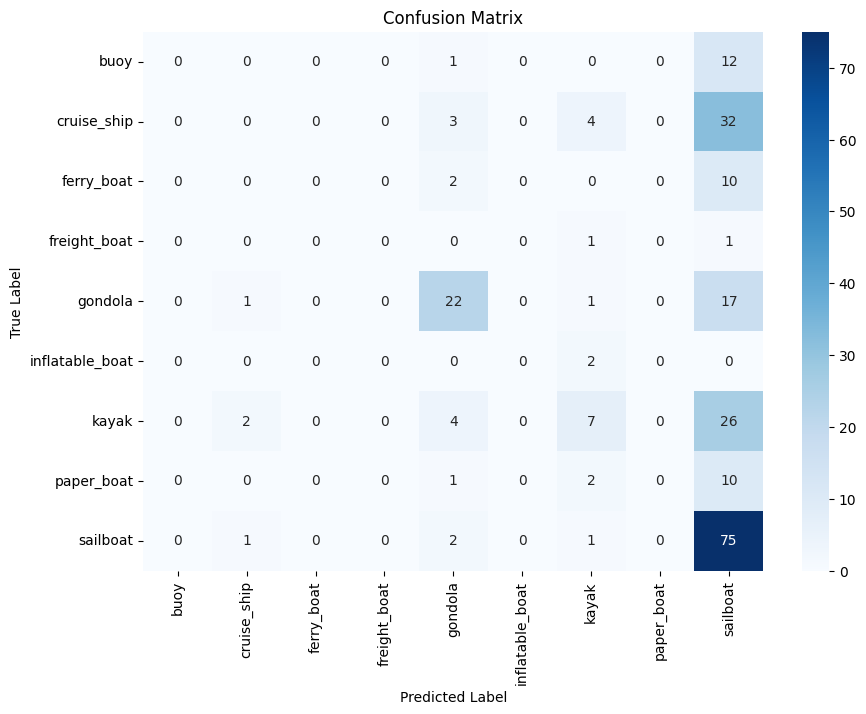

In [28]:
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels,
yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [27]:
evaluation = model.evaluate(test_generator, steps=11)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 759ms/step - accuracy: 0.2708 - loss: 1.9427 - precision: 0.3591 - recall: 0.1139


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use
any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using
Keras API.

In [29]:
import pathlib
import os

# Original dataset path
dataset_dir = "/content/drive/MyDrive/projects/Automating_Port_Datasets/boat_type_classification_dataset"

# Paths for split dataset (new folders will be created here)
transfer_train_dir = "/content/drive/MyDrive/projects/Automating_Port_Datasets/transfer_train"
transfer_test_dir  = "/content/drive/MyDrive/projects/Automating_Port_Datasets/transfer_test"


In [30]:
# Split dataset into train (70%) and test (30%)
train_dir, _, test_dir = create_train_val_test(
    dataset_dir, "/content/drive/MyDrive/projects/Automating_Port_Datasets/transfer_split",
    test_size=0.3, val_size=0.0, seed=1
)

print("Transfer Train:", train_dir)
print("Transfer Test:", test_dir)


Transfer Train: /content/drive/MyDrive/projects/Automating_Port_Datasets/transfer_split/train
Transfer Test: /content/drive/MyDrive/projects/Automating_Port_Datasets/transfer_split/test


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation from training set
)

transfer_train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    seed=43
)

transfer_validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    seed=43
)

# Test generator (no validation split)
test_datagen = ImageDataGenerator(rescale=1./255)

transfer_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=43
)


Found 663 images belonging to 9 classes.
Found 160 images belonging to 9 classes.
Found 359 images belonging to 9 classes.


In [32]:
input_shape = (180,180,3)
custom_model = MobileNetV2(
weights='imagenet',
include_top=False,
input_shape=input_shape
)


/tmp/ipython-input-2149689933.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  custom_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
# freeze training
# layername.trainable = False
for x in custom_model.layers:
  x.trainable = False

In [34]:
layer = custom_model.output
layer = GlobalAveragePooling2D()(layer)
# Add a dropout layer for some regularization
layer = Dropout(0.2)(layer)
# Add a fully connected layer
layer = Dense(256, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.1)(layer)
layer = Dense(128, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.1)(layer)
# Add a final softmax layer for classification
output_layer = Dense(9, activation='softmax')(layer)

In [35]:
custom_model_final = Model(inputs=custom_model.inputs, outputs=output_layer) #integrate all the pieces - finalization

In [36]:
custom_model_final.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy', Precision(), Recall()]
)

In [37]:
Hist = custom_model_final.fit(transfer_train_generator,
validation_data=transfer_validation_generator, epochs=50)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3865 - loss: 1.9919 - precision_1: 0.5436 - recall_1: 0.2666 - val_accuracy: 0.8062 - val_loss: 0.7100 - val_precision_1: 0.9083 - val_recall_1: 0.6812
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8463 - loss: 0.5173 - precision_1: 0.9097 - recall_1: 0.7857 - val_accuracy: 0.8438 - val_loss: 0.5636 - val_precision_1: 0.9065 - val_recall_1: 0.7875
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8657 - loss: 0.4410 - precision_1: 0.9204 - recall_1: 0.8070 - val_accuracy: 0.8313 - val_loss: 0.5172 - val_precision_1: 0.9021 - val_recall_1: 0.8062
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9368 - loss: 0.2173 - precision_1: 0.9708 - recall_1: 0.9180 - val_accuracy: 0.8562 - val_loss: 0.4541 - val_precision_1: 0.9085 - val_recall_1: 0.8062
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9367 - loss: 0.2314 - precision_1: 0.9628 - recall_1: 0.9219 - val_accur

In [38]:
test_hist = custom_model_final.evaluate(transfer_test_generator, steps=11)

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7402 - loss: 1.2264 - precision_1: 0.7443 - recall_1: 0.7288


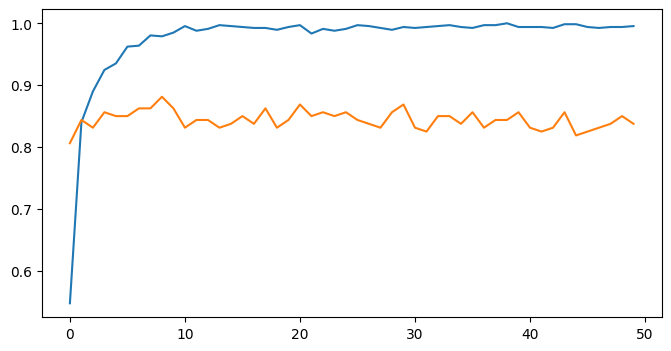

In [39]:
acc = Hist.history['accuracy']
val_acc = Hist.history['val_accuracy']
epoch_vals = range(50)
plt.figure(figsize=(8,4))
plt.plot(epoch_vals, acc, label='Training Accuracy')
plt.plot(epoch_vals, val_acc, label='Validation Accuracy')

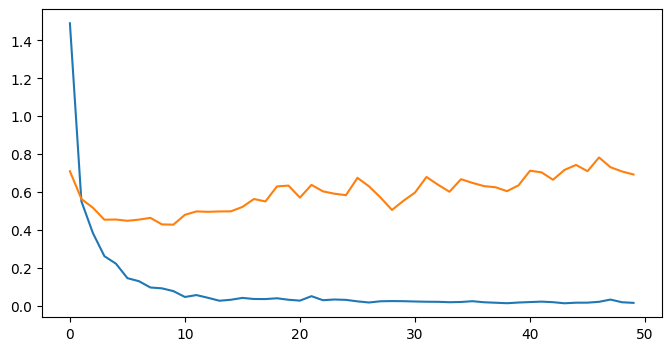

In [40]:
loss = Hist.history['loss']
val_loss = Hist.history['val_loss']
epoch_vals = range(50)
plt.figure(figsize=(8,4))
plt.plot(epoch_vals, loss, label='Training Loss')
plt.plot(epoch_vals, val_loss, label='Validation Loss')

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
[[  3   0   0   0   0   0   3   1   2]
 [  0  49   3   0   2   0   1   0   4]
 [  0   9   7   1   4   0   1   0   3]
 [  0   3   2   4   0   0   0   0   0]
 [  0   1   0   0  69   0   0   0   2]
 [  0   0   1   0   0   0   5   0   1]
 [  0   0   1   0   3   0  44   0   3]
 [  0   0   0   0   1   0   2   2   0]
 [  1   3   1   0   5   0   8   1 103]]
                 precision    recall  f1-score   support

           buoy       0.75      0.33      0.46         9
    cruise_ship       0.75      0.83      0.79        59
     ferry_boat       0.47      0.28      0.35        25
   freight_boat       0.80      0.44      0.57         9
        gondola       0.82      0.96      0.88        72
inflatable_boat       0.00      0.00      0.00         7
          kayak       0.69      0.86      0.77        51
     paper_boat       0.50      0.40      0.44         5
       sailboat       0.87      0.84      0.86       122

       accuracy                      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


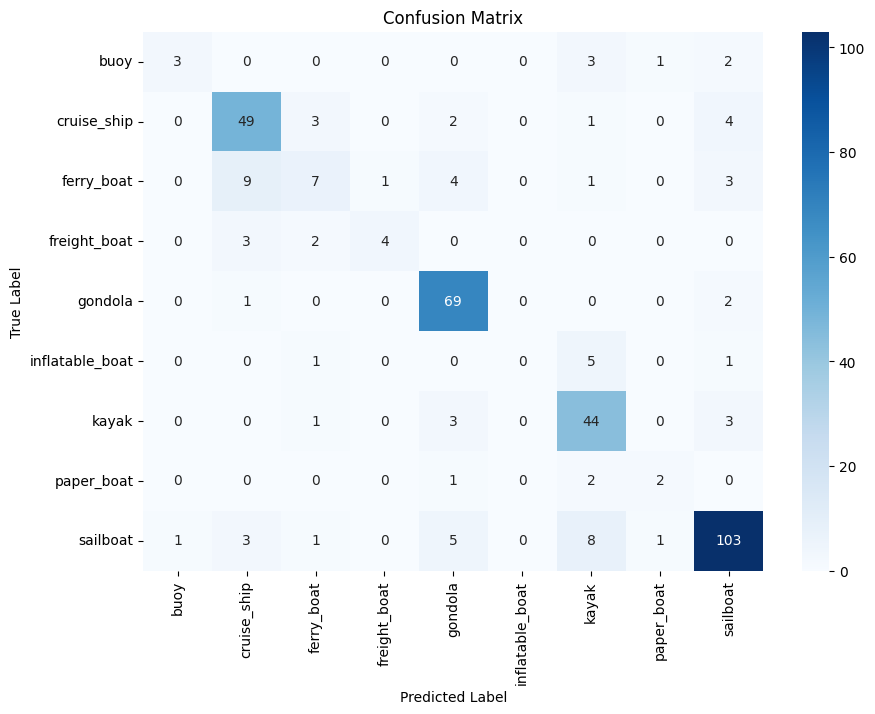

In [43]:
# Predict classes
predictions = custom_model_final.predict(transfer_test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = transfer_test_generator.classes
class_labels = list(transfer_test_generator.class_indices.keys())
CM = confusion_matrix(true_classes, predicted_classes)
print(CM)
# Generate classification report
class_report = classification_report(true_classes, predicted_classes,
target_names=class_labels)
print(class_report)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels,
yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 925ms/step
[[  3   0   0   0   0   0   3   1   2]
 [  0  49   3   0   2   0   1   0   4]
 [  0   9   7   1   4   0   1   0   3]
 [  0   3   2   4   0   0   0   0   0]
 [  0   1   0   0  69   0   0   0   2]
 [  0   0   1   0   0   0   5   0   1]
 [  0   0   1   0   3   0  44   0   3]
 [  0   0   0   0   1   0   2   2   0]
 [  1   3   1   0   5   0   8   1 103]]
                 precision    recall  f1-score   support

           buoy       0.75      0.33      0.46         9
    cruise_ship       0.75      0.83      0.79        59
     ferry_boat       0.47      0.28      0.35        25
   freight_boat       0.80      0.44      0.57         9
        gondola       0.82      0.96      0.88        72
inflatable_boat       0.00      0.00      0.00         7
          kayak       0.69      0.86      0.77        51
     paper_boat       0.50      0.40      0.44         5
       sailboat       0.87      0.84      0.86       122

       accuracy                   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


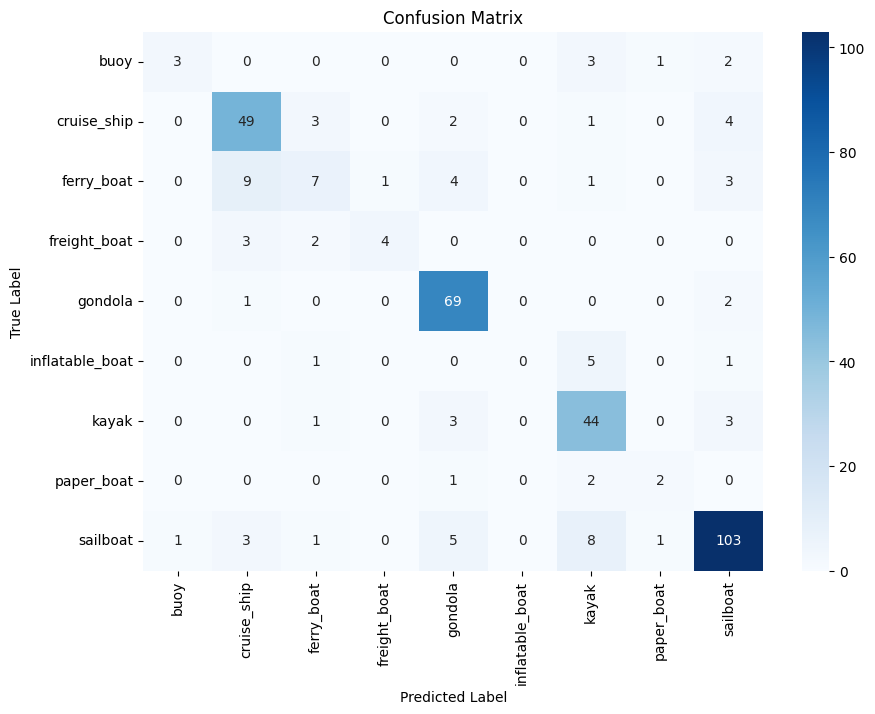

In [44]:
# Predict classes
predictions = custom_model_final.predict(transfer_test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = transfer_test_generator.classes
class_labels = list(transfer_test_generator.class_indices.keys())
CM = confusion_matrix(true_classes, predicted_classes)
print(CM)
# Generate classification report
class_report = classification_report(true_classes, predicted_classes,
target_names=class_labels)
print(class_report)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels,
yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Summary The CNN model with less number of layers/neurons provided really low accuracy.
Also the for 9 classes the data setup seems pretty insufficient. With the transfer model though
since the model is already pre trained the accuracy is really good.
It still needs better learning data to further improve accuracy.

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
[[ 0  0  0  0  1  0  3  0  4]
 [ 1  5  0  0  6  0  3  1 10]
 [ 0  0  0  0  2  0  2  0  3]
 [ 0  0  0  0  0  0  1  0  1]
 [ 0  6  2  0  3  0  7  1  9]
 [ 0  1  0  0  0  0  0  0  0]
 [ 4  5  0  0 12  0  3  1  5]
 [ 0  0  0  0  0  0  2  0  3]
 [ 2  9  3  0  7  0 13  1 18]]
                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00         8
    cruise_ship       0.19      0.19      0.19        26
     ferry_boat       0.00      0.00      0.00         7
   freight_boat       0.00      0.00      0.00         2
        gondola       0.10      0.11      0.10        28
inflatable_boat       0.00      0.00      0.00         1
          kayak       0.09      0.10      0.09        30
     paper_boat       0.00      0.00      0.00         5
       sailboat       0.34      0.34      0.34        53

       accuracy                           0.18       160
      macro avg       0.08      0.08      0.08       160
   weig

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


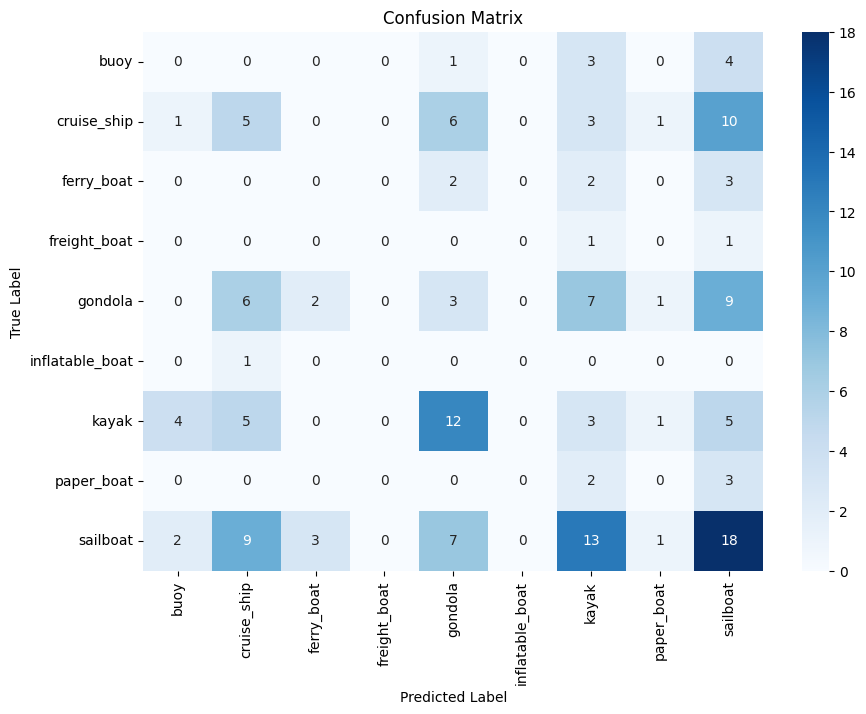

In [46]:
# Predict classes
predictions = custom_model_final.predict(transfer_validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = transfer_validation_generator.classes
class_labels = list(transfer_validation_generator.class_indices.keys())
CM = confusion_matrix(true_classes, predicted_classes)
print(CM)
# Generate classification report
class_report = classification_report(true_classes, predicted_classes,
target_names=class_labels)
print(class_report)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels,
yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [48]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Function to predict the class of a single image
def predict_image_class(model, img_path, class_labels, target_size=(180, 180)):
    """
    Predicts the class of a single image using the trained model.

    Args:
        model: The trained Keras model.
        img_path: The path to the image file.
        class_labels: A list of class labels.
        target_size: The target size for resizing the image.

    Returns:
        A tuple containing the predicted class label and the prediction probability.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    prediction_probability = predictions[0][predicted_class_index]

    return predicted_class_label, prediction_probability

# Get the list of class labels from the test generator
class_labels = list(transfer_test_generator.class_indices.keys())

# Example usage: Get input from the user for an image path
img_path = input("Enter the path to the image file: ")

# Check if the file exists
if not os.path.exists(img_path):
    print(f"Error: File not found at {img_path}")
else:
    # Predict the class and probability
    predicted_label, probability = predict_image_class(custom_model_final, img_path, class_labels)

    print(f"Predicted class: {predicted_label}")
    print(f"Prediction probability: {probability:.4f}")

Enter the path to the image file: /content/drive/MyDrive/projects/Automating_Port_Datasets/boat_type_classification_dataset/buoy/10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: kayak
Prediction probability: 0.9203


Saving images.jfif to images.jfif
User uploaded file "images.jfif" with length 9264 bytes


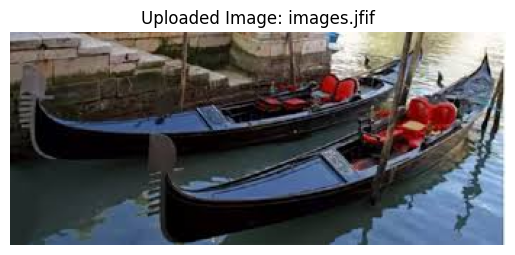

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

Predicted class: gondola
Prediction probability: 1.0000


In [50]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    # Saving uploaded file temporarily
    img_path = fn
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Display the uploaded image
    img = load_img(img_path)
    plt.imshow(img)
    plt.title(f"Uploaded Image: {fn}")
    plt.axis('off')
    plt.show()

    # Get the list of class labels from the test generator
    # Assuming transfer_test_generator is available from previous steps
    if 'transfer_test_generator' in locals():
        class_labels = list(transfer_test_generator.class_indices.keys())

        # Predict the class and probability using the existing function
        if 'predict_image_class' in locals():
            predicted_label, probability = predict_image_class(custom_model_final, img_path, class_labels)

            print(f"\nPredicted class: {predicted_label}")
            print(f"Prediction probability: {probability:.4f}")

            # Clean up the temporary file
            os.remove(img_path)
        else:
            print("Error: 'predict_image_class' function not found. Please ensure the cell defining this function has been executed.")
    else:
         print("Error: 'transfer_test_generator' not found. Please ensure the cell defining the test generator has been executed.")

Saving boat image.webp to boat image.webp
User uploaded file "boat image.webp" with length 14504 bytes


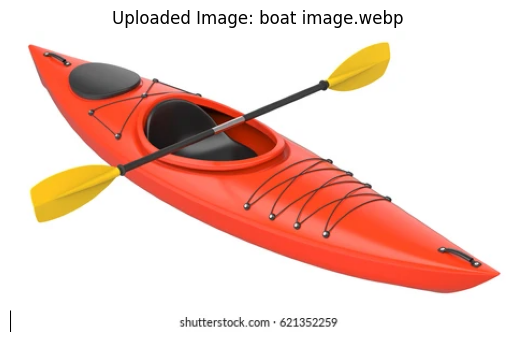

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

Predicted class: kayak
Prediction probability: 1.0000


In [51]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    # Saving uploaded file temporarily
    img_path = fn
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Display the uploaded image
    img = load_img(img_path)
    plt.imshow(img)
    plt.title(f"Uploaded Image: {fn}")
    plt.axis('off')
    plt.show()

    # Get the list of class labels from the test generator
    # Assuming transfer_test_generator is available from previous steps
    if 'transfer_test_generator' in locals():
        class_labels = list(transfer_test_generator.class_indices.keys())

        # Predict the class and probability using the existing function
        if 'predict_image_class' in locals():
            predicted_label, probability = predict_image_class(custom_model_final, img_path, class_labels)

            print(f"\nPredicted class: {predicted_label}")
            print(f"Prediction probability: {probability:.4f}")

            # Clean up the temporary file
            os.remove(img_path)
        else:
            print("Error: 'predict_image_class' function not found. Please ensure the cell defining this function has been executed.")
    else:
         print("Error: 'transfer_test_generator' not found. Please ensure the cell defining the test generator has been executed.")

Saving images (1).jfif to images (1).jfif
User uploaded file "images (1).jfif" with length 9854 bytes


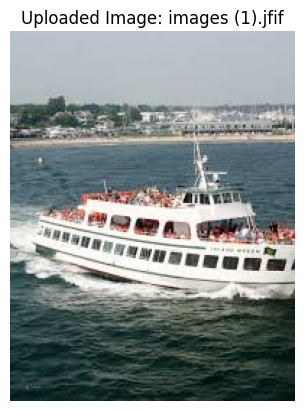

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Predicted class: ferry_boat
Prediction probability: 0.9953


In [52]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    # Saving uploaded file temporarily
    img_path = fn
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Display the uploaded image
    img = load_img(img_path)
    plt.imshow(img)
    plt.title(f"Uploaded Image: {fn}")
    plt.axis('off')
    plt.show()

    # Get the list of class labels from the test generator
    # Assuming transfer_test_generator is available from previous steps
    if 'transfer_test_generator' in locals():
        class_labels = list(transfer_test_generator.class_indices.keys())

        # Predict the class and probability using the existing function
        if 'predict_image_class' in locals():
            predicted_label, probability = predict_image_class(custom_model_final, img_path, class_labels)

            print(f"\nPredicted class: {predicted_label}")
            print(f"Prediction probability: {probability:.4f}")

            # Clean up the temporary file
            os.remove(img_path)
        else:
            print("Error: 'predict_image_class' function not found. Please ensure the cell defining this function has been executed.")
    else:
         print("Error: 'transfer_test_generator' not found. Please ensure the cell defining the test generator has been executed.")